<a href="https://colab.research.google.com/github/tusharrjadhav/Skin_ml_model_notebook/blob/main/Skin_Cancer_Prediction_InceptionResNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Skin Cancer Classification Transfer Learning InceptionResNetV2

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn

### Download the HAM_Dataset

### Creating Dataset

In [2]:
os.mkdir("HAM_Dataset")
base = "HAM_Dataset"

os.mkdir(os.path.join(base, "MEL"))
os.mkdir(os.path.join(base, "NV"))
os.mkdir(os.path.join(base, "BCC"))
os.mkdir(os.path.join(base, "AKIEC"))
os.mkdir(os.path.join(base, "BKL"))
os.mkdir(os.path.join(base, "DF"))
os.mkdir(os.path.join(base, "VASC"))

print(os.listdir(base))

['BKL', 'AKIEC', 'BCC', 'DF', 'MEL', 'NV', 'VASC']


### Set up Kaggle API for dataset download

To download datasets from Kaggle, you need to set up your Kaggle API credentials. Follow these steps:

1.  Go to [Kaggle](https://www.kaggle.com/).
2.  Click on your profile picture in the top right corner and select 'My Account'.
3.  Scroll down to the 'API' section and click 'Create New API Token'. This will download a `kaggle.json` file.
4.  Open `kaggle.json` with a text editor. It contains your username and key.
5.  In Colab, go to the 'Secrets' tab (🔑 icon on the left panel).
6.  Add two new secrets: `KAGGLE_USERNAME` and `KAGGLE_KEY`, and paste the respective values from your `kaggle.json` file.

In [3]:
import os
from google.colab import userdata

# Install Kaggle API client
!pip install -q kaggle

# Create .kaggle directory if it doesn't exist
!mkdir -p ~/.kaggle

# Write Kaggle credentials to kaggle.json file
# Fetch credentials from Colab Secrets
kaggle_username = userdata.get('KAGGLE_USERNAME')
kaggle_key = userdata.get('KAGGLE_KEY')

with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write(f'{{"username":"{kaggle_username}","key":"{kaggle_key}"}}')

# Set permissions for kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

print('Kaggle API setup complete.')

Kaggle API setup complete.


### Download HAM10000 dataset from Kaggle

Now we will download the `kmader/skin-cancer-mnist-ham10000` dataset, which is the HAM10000 dataset you linked, available on Kaggle. We will then unzip the image files.

In [4]:
# Download the dataset
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

# Create a directory for the dataset and unzip
!mkdir -p ham10000_dataset
!unzip -q skin-cancer-mnist-ham10000.zip -d ham10000_dataset/

print('HAM10000 dataset downloaded and unzipped.')
print(os.listdir('ham10000_dataset/'))

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.19G/5.20G [01:30<00:01, 13.9MB/s]
100% 5.20G/5.20G [01:30<00:00, 61.7MB/s]
HAM10000 dataset downloaded and unzipped.
['hmnist_8_8_RGB.csv', 'hmnist_28_28_RGB.csv', 'ham10000_images_part_2', 'ham10000_images_part_1', 'HAM10000_images_part_1', 'hmnist_8_8_L.csv', 'hmnist_28_28_L.csv', 'HAM10000_images_part_2', 'HAM10000_metadata.csv']


In [5]:
# Ensure all images are in a single folder for processing
import shutil
import os

image_folder = 'ham10000_images'
os.makedirs(image_folder, exist_ok=True)

# Source directories after initial unzip
part1_source_dir = 'ham10000_dataset/HAM10000_images_part_1'
part2_source_dir = 'ham10000_dataset/HAM10000_images_part_2'

print(f"Copying images from {part1_source_dir}...")
for filename in os.listdir(part1_source_dir):
    if filename.endswith('.jpg'):
        shutil.copy(os.path.join(part1_source_dir, filename), image_folder)

print(f"Copying images from {part2_source_dir}...")
for filename in os.listdir(part2_source_dir):
    if filename.endswith('.jpg'):
        shutil.copy(os.path.join(part2_source_dir, filename), image_folder)

print(f'Total images in {image_folder}: {len(os.listdir(image_folder))}')

Copying images from ham10000_dataset/HAM10000_images_part_1...
Copying images from ham10000_dataset/HAM10000_images_part_2...
Total images in ham10000_images: 10015


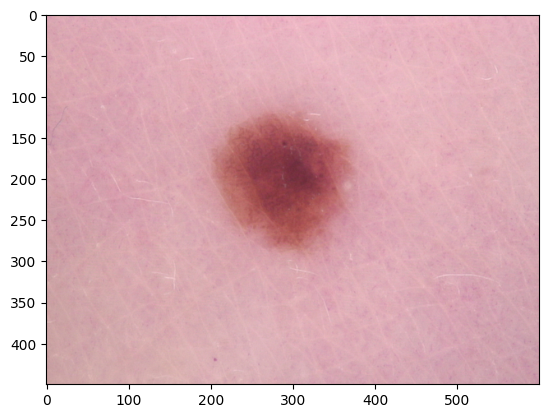

(450, 600, 3)


In [6]:
img = os.listdir('ham10000_images')[0]
skin=cv2.imread('ham10000_images/'+img)
plt.imshow(cv2.cvtColor(skin, cv2.COLOR_BGR2RGB))
plt.show()

print(skin.shape)

In [7]:
mapping = {
    'akiec': 'AKIEC',
    'bcc': 'BCC',
    'bkl': 'BKL',
    'df': 'DF',
    'mel': 'MEL',
    'nv': 'NV',
    'vasc': 'VASC'
}

df_labels = pd.read_csv('ham10000_dataset/HAM10000_metadata.csv')
df_labels['label'] = df_labels['dx'].map(mapping)
# Rename 'image_id' to 'image' to match subsequent usage
df_labels.rename(columns={'image_id': 'image'}, inplace=True)
df_labels.set_index('image', inplace=True)

# Ensure all images in the image_folder have corresponding entries in df_labels
# This step is crucial if there are discrepancies between metadata and image files
# For HAM10000, usually all images are covered by the metadata.
# Also, drop any rows where label might be NaN if dx was not in mapping (shouldn't happen with ham10000)
df_labels.dropna(subset=['label'], inplace=True)

print(df_labels.head())

                lesion_id   dx dx_type   age   sex localization label
image                                                                
ISIC_0027419  HAM_0000118  bkl   histo  80.0  male        scalp   BKL
ISIC_0025030  HAM_0000118  bkl   histo  80.0  male        scalp   BKL
ISIC_0026769  HAM_0002730  bkl   histo  80.0  male        scalp   BKL
ISIC_0025661  HAM_0002730  bkl   histo  80.0  male        scalp   BKL
ISIC_0031633  HAM_0001466  bkl   histo  75.0  male          ear   BKL


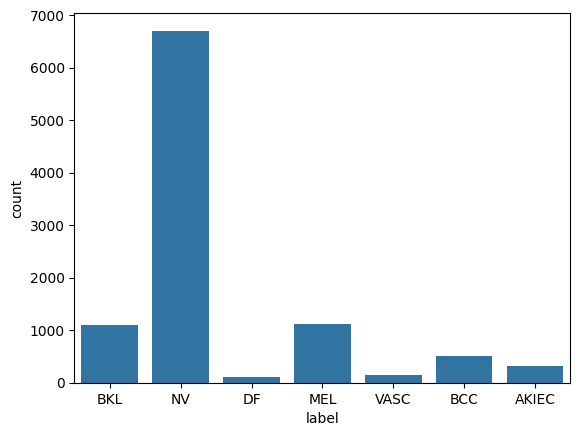

In [8]:
sns.countplot(x=df_labels["label"])
plt.show()

In [9]:
from sklearn.utils import class_weight
import numpy as np

class_names = np.unique(df_labels["label"])
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=class_names,
                                                  y=df_labels["label"])
class_wt_dict=dict(enumerate(class_weights))
class_wt_dict

{0: np.float64(4.375273044997815),
 1: np.float64(2.78349082823791),
 2: np.float64(1.301832835044846),
 3: np.float64(12.440993788819876),
 4: np.float64(1.2854575792581184),
 5: np.float64(0.21338020666879728),
 6: np.float64(10.075452716297788)}

In [10]:
from tqdm import tqdm

images = os.listdir('ham10000_images')

for image in tqdm(images):
    fname=image[:-4] # Remove .jpg extension to match DataFrame index
    if fname in df_labels.index: # Check if the image has a corresponding label
        label=df_labels.loc[fname, "label"]
        src = os.path.join('ham10000_images', image)
        dst = os.path.join('HAM_Dataset', label, image)
        shutil.copyfile(src, dst)
    else:
        print(f"Warning: Image {image} not found in metadata. Skipping.")


100%|██████████| 10015/10015 [00:21<00:00, 455.27it/s]


### Train Test Split

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import preprocess_input as base_preprocess


image_gen = ImageDataGenerator(
                               preprocessing_function=base_preprocess,
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               fill_mode='nearest',
                               # rescale=1/255,
                               validation_split=0.15)

data_dir = 'HAM_Dataset'
batch_size = 64
target_size = (224,224)
train_image_gen = image_gen.flow_from_directory(data_dir,
                                          target_size=target_size,
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          subset="training")

test_image_gen = image_gen.flow_from_directory(data_dir,
                                          target_size=target_size,
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False,
                                          subset="validation")

print(test_image_gen.class_indices)

Found 8516 images belonging to 7 classes.
Found 1499 images belonging to 7 classes.
{'AKIEC': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'VASC': 6}


<Axes: ylabel='count'>

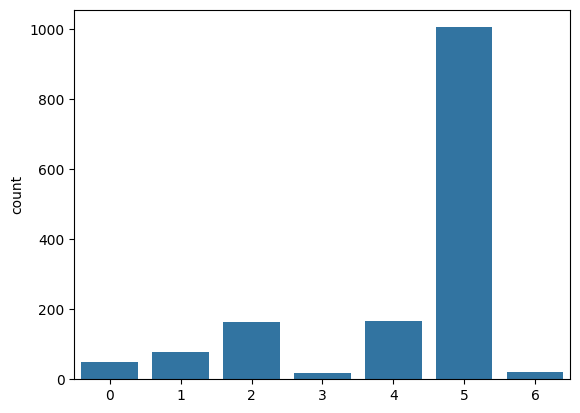

In [12]:
sns.countplot(x=test_image_gen.classes)

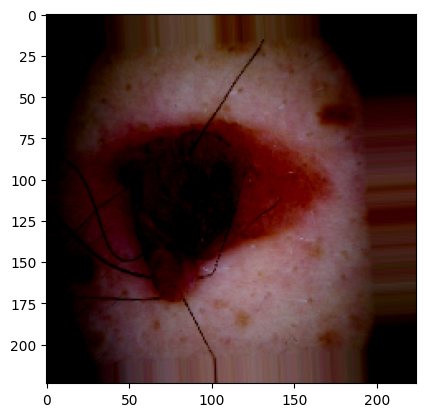

In [13]:
plt.imshow(train_image_gen[0][0][0])

## Transfer Learning using InceptionResNetV2 Model

In [14]:
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = Flatten()(x)
# x = Dense(4096, activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)
x = Dense(128,kernel_regularizer='l2',activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)
tl_model = Model(inputs=base_model.input, outputs=x)


tl_model.summary()

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 54,534,375 (208.03 MB)

 Trainable params: 54,473,831 (207.80 MB)

 Non-trainable params: 60,544 (236.50 KB)

In [15]:
optimizer = Adam(0.0001)
tl_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

### Model Training

In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2,mode='max', min_lr=0.00001,verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=2, verbose=1)
model_chkpt = ModelCheckpoint('best_model_dn121.keras',save_best_only=True, monitor='val_accuracy',verbose=1)

callback_list = [model_chkpt,lr_reduce]

In [17]:
history = tl_model.fit(train_image_gen,
                       epochs=15,
                       validation_data = test_image_gen,
                       class_weight=class_wt_dict,
                       callbacks=callback_list)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3764 - loss: 3.9243
Epoch 1: val_accuracy improved from -inf to 0.69046, saving model to best_model_dn121.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 544s 3s/step - accuracy: 0.3772 - loss: 3.9220 - val_accuracy: 0.6905 - val_loss: 3.0816 - learning_rate: 1.0000e-04
Epoch 2/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6427 - loss: 2.8827
Epoch 2: val_accuracy improved from 0.69046 to 0.73182, saving model to best_model_dn121.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.6428 - loss: 2.8822 - val_accuracy: 0.7318 - val_loss: 2.5854 - learning_rate: 1.0000e-04
Epoch 3/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6973 - loss: 2.4744
Epoch 3: val_accuracy improved from 0.73182 to 0.73516, saving model to best_model_dn121.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.6973 - loss: 2.4740 - val_accuracy: 0.7352 - val_loss: 2.4087 - learning_rate: 1.0000e-04
Epoch 4/15
134/134 ━━━━━━

### Model Evaluation

In [18]:
df=pd.DataFrame(tl_model.history.history)
df.to_csv('hist3.csv')

<Axes: >

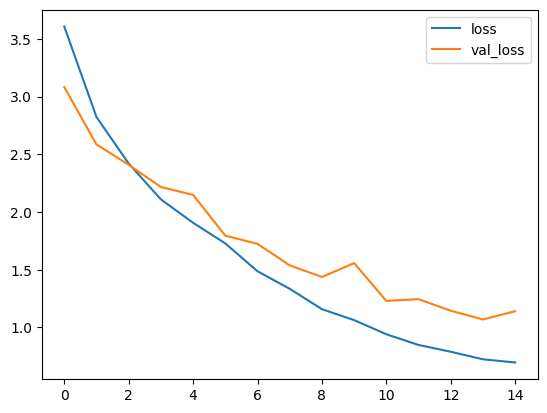

In [19]:
metrics = pd.DataFrame(tl_model.history.history)
metrics[["loss","val_loss"]].plot()

<Axes: >

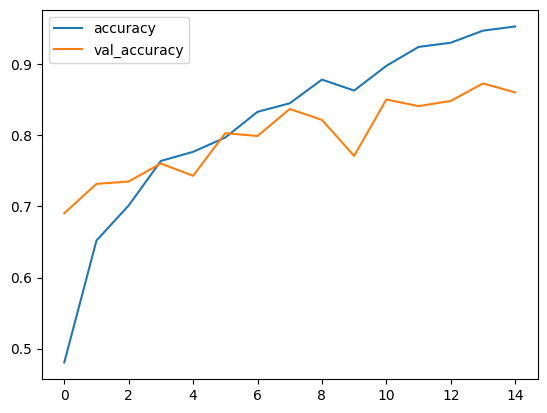

In [20]:
metrics[["accuracy","val_accuracy"]].plot()

In [21]:
predictions = tl_model.predict(test_image_gen, verbose=1)
predictions = predictions.argmax(axis=1)

test_labels = test_image_gen.classes

24/24 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step


In [22]:
pred_df = pd.DataFrame({"true":test_labels, "pred":predictions})
pred_df.to_csv("pred_df.csv")

In [24]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.63      0.67      0.65        49
           1       0.74      0.92      0.82        77
           2       0.79      0.75      0.77       164
           3       1.00      0.82      0.90        17
           4       0.61      0.70      0.65       166
           5       0.95      0.91      0.93      1005
           6       0.66      1.00      0.79        21

    accuracy                           0.86      1499
   macro avg       0.77      0.83      0.79      1499
weighted avg       0.87      0.86      0.87      1499



Normalized confusion matrix
[[0.67346939 0.16326531 0.10204082 0.         0.04081633 0.02040816
  0.        ]
 [0.01298701 0.92207792 0.01298701 0.         0.01298701 0.03896104
  0.        ]
 [0.04878049 0.02439024 0.75       0.         0.07317073 0.09756098
  0.00609756]
 [0.05882353 0.05882353 0.         0.82352941 0.05882353 0.
  0.        ]
 [0.03012048 0.03012048 0.06024096 0.         0.69879518 0.15060241
  0.03012048]
 [0.0039801  0.00696517 0.0159204  0.         0.05870647 0.90945274
  0.00497512]
 [0.         0.         0.         0.         0.         0.
  1.        ]]


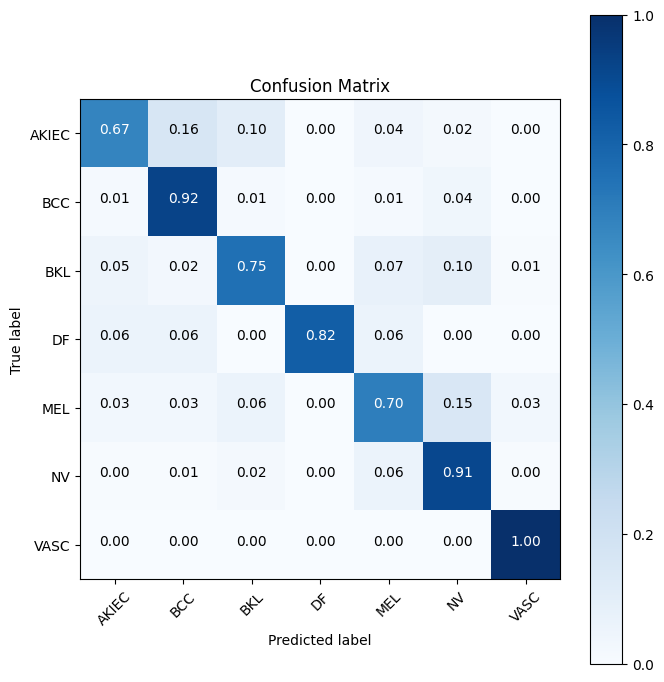

In [26]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


cm_plot_labels = list(test_image_gen.class_indices.keys())
cm = confusion_matrix(test_labels, predictions)

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)

### Convert .keras to .tflite

In [27]:
import tensorflow as tf

# 1. Load your trained model
model = tf.keras.models.load_model('/content/best_model_dn121.keras')

# 2. Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# 3. Save the .tflite file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp_dgo4wg_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  135089857977168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135089857978896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135089857978320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135089857977744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135089857978512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135089857979664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135089857977552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135089857977936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135089857979280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135089857980432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135089857976976